# TP 4 RNNs: classification de séquences, forecasting, génération de séquences, one-hot encoding

_Ismaël Bonneau_

Ce notebook sert uniquement à présenter nos résultats, et les bouts de code intéressants dans le cadre de ce rapport. L'intégralité du code est contenu dans le fichier tp4.py.

## But

- implémenter un RNN en pytorch
- réaliser une tâche de classification de séquence
- réaliser une tâche de forecasting (prédiction de caracètre)

## Données

2 jeux de données sont fournis: un jeu de relevés de température à travers 31 villes des Etats Unis et du Canada, qui pourra servir à de la classification de séquence (many to one), par exemple pour prédire une ville sachant une séquence de température, ou à du forecasting, en préduisant la température à ${t+1}$. L'autre est un jeu de données de discours de trump, qui pourra servir essentiellement à du forecasting.

In [1]:
import numpy as np
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

import models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
temperatures_csv = pd.read_csv("data/tempAMAL_train.csv")
print("Nb exemples: {}, cities: {}".format(temperatures_csv.shape[0], temperatures_csv.shape[1]))

temperatures_csv.head(5)

Nb exemples: 11115, cities: 31


,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston
0,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,284.030000,298.170000,288.650000,299.720000,281.000000,286.260000,285.630000,288.220000,285.830000,287.170000
1,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,284.069789,298.205230,288.650172,299.732518,281.024767,286.262541,285.663208,288.247676,285.834650,287.186092
2,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,284.173965,298.299595,288.650582,299.766579,281.088319,286.269518,285.756824,288.326940,285.847790,287.231672
3,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,284.278140,298.393961,288.650991,299.800641,281.151870,286.276496,285.850440,288.406203,285.860929,287.277251
4,2012-10-01 17:00:00,284.622911,282.109095,289.431869,281.775065,291.852162,291.563063,293.370249,296.677445,285.392738,...,284.382316,298.488326,288.651401,299.834703,281.215421,286.283473,285.944057,288.485467,285.874069,287.322831


### Construisons le jeu de données

On va construire un dataset et un dataLoader associé qui vont contenir nos séquences et batches associés. On procède comme suit:

- On sample au hasard 10 villes


In [14]:
nbclass = 10 # prendre nbclass = 10 villes pour la tache de classif de séquences
seq_len = 20 # prendre une longueur de séquence de taille fixe pour le moment
nb_sequences = 300 # prendre 300 séquences par ville

cities = np.random.choice(temperatures_csv.columns[1:], nbclass, replace=False) # ne pas sélectionner le datetime

def sample_sequence(city):
    start = np.random.randint(0, temperatures_csv.shape[0] - seq_len)
    return np.array(temperatures_csv[city][start:start + seq_len])

sequences = []
labels = []
for i, city in enumerate(cities):
    j = 0
    while j < nb_sequences:
        s = sample_sequence(city)
        if not np.isnan(s).any(): # certains nan peuvent être présents dans le dataframe
            sequences.append(s)
            labels.append(i)
            j += 1
        
sequences = np.array(sequences)
labels = np.array(labels)
sequences /= np.max(sequences) # normaliser
#sequences, labels = shuffle(sequences, labels, random_state=1997) # shuffle lines
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=1997)

X_train = np.expand_dims(X_train, axis=2) # pour créer une dimension supplémentaire de taille 1
X_test = np.expand_dims(X_test, axis=2)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
print(X_train.shape, X_test.shape)

print(list(cities))

(2400, 20, 1) (600, 20, 1)
['Kansas City', 'Seattle', 'Indianapolis', 'Nashville', 'Charlotte', 'Vancouver', 'Albuquerque', 'Miami', 'Denver', 'Minneapolis']


Le RNN que nous avons codé attend en entrée des matrices de taille sequence_length x batch x dim. Dans notre cas où nous avons pris des séquences de taille 20, on aurait donc des matrices de taille 20 x batch x 1, car nos données sont en dimension 1.

On va donc swaper les dimensions 0 et 1 de notre array de séquences:

In [15]:
print(X_train.shape)
X_train = np.swapaxes(X_train,0,1)
X_test = np.swapaxes(X_test,0,1)
print(X_train.shape)

(2400, 20, 1)
(20, 2400, 1)


### Un petit dataset pour le RNN s'impose:

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Dataset_RNN(Dataset):
    """Dataset avec la taille de batch en axis 1 au lieu de 0.
        Pas mal pour notre RNN"""
    def __init__(self, x, y):
        super(Dataset_RNN, self).__init__()
        self.labels = torch.from_numpy(y)
        self.data = torch.from_numpy(x).float()
    def __getitem__(self, index):
        return self.data[:,index,:], self.labels[index]
    def __len__(self):
        return len(self.labels)

## Modèles

### Le code du RNN: 

In [12]:
class RNN(torch.nn.Module):
    """docstring for RNN"""
    def __init__(self, dim, latent):
        super(RNN, self).__init__()
        self.dim = dim
        self.latent = latent
        self.Wx = torch.nn.Linear(dim, latent)
        self.Wh = torch.nn.Linear(latent, latent)

    def forward(self, x, h=None):
        """ x: sequence_length x batch x dim 
            h: batch x latent
            returns: length x batch x latent Tensor"""
        historique = []
        # pour chaque instant de la sequence:
        if h is None:
            ht = torch.zeros(x.size()[1], self.latent)
        for i, xt in enumerate(x):
            # ht: (batch x latent)
            ht = self.one_step(xt, ht)
            historique.append(ht)
        return historique

    def one_step(self, x, h):
        """ x: batch x dim 
            h: batch x latent
            returns: batch x latent Tensor """
        return torch.nn.functional.leaky_relu(self.Wx(x) + self.Wh(h))

### Le code du decoder qui va permettre de passer de ${h_{T}}$ à une classe

In [7]:
class Decoder(torch.nn.Module):
    """ simple Neural Net """
    def __init__(self, inSize, outSize, layers=[]):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([])
        for x in layers:
            self.layers.append(nn.Linear(inSize, x))
            inSize = x
        self.layers.append(nn.Linear(inSize, outSize))

    def forward(self, x):
        q = self.layers[0](x)
        for i in range(1, len(self.layers)):
            q = torch.tanh(q)
            q = self.layers[i](q)
        return torch.sigmoid(q)

### SequenceClassifier: contient un RNN et un decoder.

In [8]:
class SequenceClassifier(torch.nn.Module):
    """ """
    def __init__(self, dim, latent, nbClass):
        super(SequenceClassifier, self).__init__()
        self.rnn = RNN(dim, latent)
        self.decoder = Decoder(latent, nbClass, layers=[8, 16, 8])

    def forward(self, x):
        """ """
        h = self.rnn(x)
        hT = h[-1] # on utilise uniquement la dernière sortie du RNN, celle de fin de séquence
        return self.decoder(hT)

## Expérimentations

Nous allons expérimenter avec le réseau de neurones.

- Criterion: Cross entropy loss
- Validation mesure: accuracy (que l'on peut utiliser car classes équilibrées)

In [16]:
train_dataset = Dataset_RNN(X_train, y_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=240, shuffle=True)
test_dataset = Dataset_RNN(X_test, y_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=240, shuffle=False)

In [10]:
from torch.utils.tensorboard import SummaryWriter

def accuracy(logit, labels):
    predicted = (torch.max(logit, 1)[1].view(labels.size()).data == labels.data).sum()
    return predicted.item() / len(labels)

In [17]:
import time

latentdim = 10
inputdim = 1 # on input des températures => scalaires

rnn = SequenceClassifier(inputdim, latentdim, len(cities))

criterion = nn.CrossEntropyLoss() # pas besoin de one-hot pour les labels avec cette fct là
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

epochs = 100

validation_accuracy = []
training_accuracy = []

writer = SummaryWriter()

start = time.time()

for e in range(epochs):
    losses = []
    accs_train = []
    for seq_batch, label_batch in train_dataloader:
        optimizer.zero_grad()
        preds = rnn(seq_batch.permute(1, 0, 2))
        with torch.no_grad():
            accs_train.append(accuracy(preds, label_batch))
        loss = criterion(preds, label_batch)
        loss.backward()
        #print("Wh grad:", rnn.rnn.Wh.weight.grad)
        #print("Wx grad:", rnn.rnn.Wh.weight.grad)
        optimizer.step()
        losses.append(loss.item())
    
    accs_val = []
    with torch.no_grad():
        for seq_batch, label_batch in test_dataloader:
            preds = rnn(seq_batch.permute(1, 0, 2))
            accs_val.append(accuracy(preds, label_batch))
    
    #writer.add_scalar('Loss/train', epoch_losses[-1], e)
    if e % 10 == 0:
        print("epoch {} training loss {}".format(e, np.mean(losses)))
        print("\ttrain accuracy: {}".format(np.mean(accs_train)))
        print("******************************************")
        
    validation_accuracy.append(np.mean(accs_val))
    training_accuracy.append(np.mean(accs_train))
    
writer.close()
print("took {}s to complete.".format(time.time() - start))

epoch 0 training loss 2.3041378259658813
	train accuracy: 0.10083333333333333
******************************************
epoch 10 training loss 2.3023861169815065
	train accuracy: 0.10291666666666668
******************************************
epoch 20 training loss 2.3021155834197997
	train accuracy: 0.10291666666666666
******************************************
epoch 30 training loss 2.301916766166687
	train accuracy: 0.10291666666666668
******************************************
epoch 40 training loss 2.3009891748428344
	train accuracy: 0.10291666666666668
******************************************
epoch 50 training loss 2.2455259561538696
	train accuracy: 0.18375000000000002
******************************************
epoch 60 training loss 2.2146883487701414
	train accuracy: 0.19125
******************************************
epoch 70 training loss 2.204490065574646
	train accuracy: 0.19458333333333333
******************************************
epoch 80 training loss 2.20050077438354

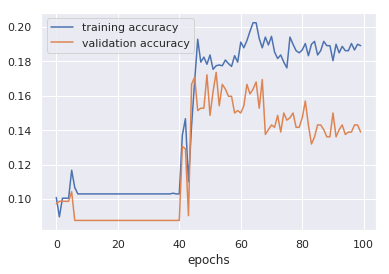

In [18]:
plt.plot(list(range(epochs)), training_accuracy, label="training accuracy")
plt.plot(list(range(epochs)), validation_accuracy, label="validation accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

### Pour 10 classes, une accuracy en test supérieure à 18% est bien meilleure que l'aléatoire (10%).

In [ ]:
PATH = './rnn.pth'
torch.save(rnn.state_dict(), PATH)